Plotting functions to plot data, provided in output folder

In [1]:
# import required module
import numpy as np
import os
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
plt.style.use(hep.style.CMS)

N_exp = {'tttt': 1850, 'ttWl': 33941, 'ttZl': 35563, 'ttWq': 68910, 'ttZq': 82979, 'WZ3l': 275153, 'WZ2l': 855600,
        'ttl': 12199200, 'ttH': 29118, 'ZZl':346656, 'ZZq':1213296, 'ttg': 306360, 'tWZ': 415, 'DY1':5244000, 
        'DY2': 173880, 'DY3': 77280, 'AH': 1380}

def read_file(f):
    df = pd.read_csv(f, sep="\t")
    return df

def get_combined_data(directory):
    dfs = [read_file(os.path.join(directory, f)) for f in os.listdir(directory)]
    SumWeight = np.sum([df.sumWeight[0] for df in dfs])
    DF = pd.concat(dfs, ignore_index=True)
    DF['SumWeight']= SumWeight
    return DF
     
def get_hist(DF, nbins, var):
    DF['w'] = DF.genWeights * (DF.N_exp / DF.SumWeight)
    DF['w2'] = np.square(DF.w)
    if type(nbins)==int:
        clipped = DF[var]
    else:
        clipped = np.clip(DF[var], nbins[0], nbins[-1])
    
    hist, _ = np.histogram(clipped, bins=nbins, weights=DF.w)
    w2, _ = np.histogram(clipped, bins=nbins, weights=DF.w2)
    w = np.sqrt(w2)
    return hist, w

def combine_bins(data):
    return [sum(x) for x in zip(*data)]

def combine_w2s(w2s):
    return [np.sqrt(sum(np.square(x))) for x in zip(*w2s)]

def get_Signal_BG(background, signal):
    BG = np.sum(background, axis=0)
    BG2 = np.sqrt(BG)
    S_BG2 = signal/BG2
    return S_BG2

def make_layout(var, ratios):
    xlabels = {"eta" : "$\eta$", "pt": "$p_T$ (GeV)", "mass": "mass (GeV)", 'M_sd': r'$M_{SD}$ (GeV)', 'AK8pt': r'$p_{T, AK8}$ (GeV)',
               'leppt':r'$p_{T, lep}$ (GeV)', 'AK4pt': r'$p_{T, AK4}$ (GeV)',
                "phy": "$\phi$", "CA": r"$\Delta^{t}_{\eta}$", "dR": r"$\Delta{r}$", "t32": r"$\tau_{32}$", 'n': 'N', 'Ht': r'H$_T$ (GeV)'}
    if (ratios!='None'):
        fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(9, 6), sharex=True, 
                                    gridspec_kw={'height_ratios': [3, 1]})
        ax0.yaxis.set_label_coords(-0.1, -6)
        ax0.set_ylabel(r'N$_{events}$', fontsize=20)
        ax1.set_xlabel(xlabels[var], fontsize=20)
        ax1.set_ylim(0, 3.1)
        ax1.set_ylabel(ratios, fontsize=16)
        ax1.xaxis.set_label_coords(1, -0.5)
        ax1.set_xlim(left=0)
        ax1.set_ylim(bottom=0)
        #ax1.yaxis.set_label_coords(-0.1, 0.6)
        plt.tight_layout()
        plt.subplots_adjust(hspace=0)
        return ax0, ax1
        
    else:
        fig, ax = plt.subplots(figsize=(7, 5))
        ax.set_ylabel(r'N$_{events}$', fontsize=20)
        ax.set_xlabel(xlabels[var], fontsize=20)
        #ax.set_xscale('log')
        return ax

def colors_labels(labels):
    c = {'ttZ': "#3f90da", 'ttW': "#bd1f01" , 'DYJets': "#ffa90e", 'ttH': "#94a4a2", 'tt': "#832db6", 'ZZ': "#a96b59",
         'WZ': "#b9ac70", 'other':  "#e76300", 'ZZ2': "#717581", 'WZ2': "#92dadd", 'ttG': 'g', 'tWZ': 'b'}
    l = {'ttZ': r't$\bar{t}$Z', 'ttW': r't$\bar{t}$W' , 'DYJets': "DY+Jets", 'ttH': r't$\bar{t}$H', 'tt': r't$\bar{t}$', 'ZZ': "ZZ",
         'WZ': "WZ", 'other':  "other", 'ZZ2': "ZZ", 'WZ2': "WZ", 'ttG': r't$\bar{t}\gamma$', 'tWZ': 'tWZ'}
    return [c[lab] for lab in labels], [l[lab] for lab in labels]

def plot(title, data, w2s, bins, var, labels, ratio):
    c, l = colors_labels(labels)
    width = (bins[0] + bins[1]) / 2
    midpoints = (bins[:-1] + bins[1:]) / 2
    edges = midpoints - width
    #edges = bins[:-1]
    if ratio=='None':
        ax = make_layout(var, 'None')
        #ax.set_title(title, size=16, y=1.2)
        hep.cms.label(ax=ax, fontsize=16, llabel='Simulation Internal', rlabel=r'138 fb$^{-1}$ (13 TeV)')
        hep.histplot(data, bins, histtype='fill', color=c, stack=True, ax=ax, label=l, binwnorm=None, ec='black', alpha=0.9)
        opts = {'step': 'post', 'label': 'Stat. unc.', 'hatch': '///',
                        'facecolor': 'none', 'edgecolor': (0, 0, 0, .5), 'linewidth': 0}
        #ax.fill_between(x=edges, y1=data-np.sqrt(w2s), y2=data+np.sqrt(w2s), **opts)
        ax.fill_between(x=edges, y1=np.sum(data, axis=0)-w2s, y2=np.sum(data, axis=0)+w2s, **opts)
        ax.legend(fontsize=16)
    if ratio =='SBG':
        ax, ax2 = make_layout(var, r'S/$\sqrt{BG}$')
        #ax.set_title(title, size=16, y=1.2)
        hep.cms.label(ax=ax, fontsize=16, llabel='Simulation Internal', rlabel=r'138 fb$^{-1}$ (13 TeV)')
        hep.histplot(data, bins, histtype='fill', color=c, stack=True, ax=ax, label=l, binwnorm=None, ec='black')
        opts = {'step': 'post', 'label': 'Stat. unc.', 'hatch': '///',
                        'facecolor': 'none', 'edgecolor': (0, 0, 0, .5), 'linewidth': 0}
        ax.fill_between(x=edges, y1=np.sum(data, axis=0)-w2s, y2=np.sum(data, axis=0)+w2s, **opts)
        ax.legend(fontsize=16)
        SBG = get_Signal_BG(data[::-1], data[-1])
        ax2.scatter(midpoints, SBG, color='black', marker='+')
        #ax2.legend(fontsize=16, loc='upper left')
    return ax

In [2]:
def get_ttZ2lhists(path, bins, var):
    DF_ttZ = get_combined_data('{}/output_TTZ'.format(path))
    DF_ttG = get_combined_data('{}/output_TTG'.format(path))
    DF_ttW = get_combined_data('{}/output_TTW'.format(path))
    DF_ttH = get_combined_data('{}/output_TTH'.format(path))
    DF_tWZ = get_combined_data('{}/output_TWZ'.format(path))
    DF_tt = get_combined_data('{}/output_TT1'.format(path))
    DF_WZ = get_combined_data('{}/output_WZ'.format(path))
    DF_WZ2 = get_combined_data('{}/output_WZ2'.format(path))
    DF_DY1 = get_combined_data('{}/output_DY1'.format(path))
    DF_DY2 = get_combined_data('{}/output_DY2'.format(path))
    DF_DY3 = get_combined_data('{}/output_DY3'.format(path))
    DF_ZZ1 = get_combined_data('{}/output_ZZ1'.format(path))
    DF_ZZ2 = get_combined_data('{}/output_ZZ2'.format(path))
    hist_ttZ, w2_ttZ = get_hist(DF_ttZ, bins, var)
    hist_ttW, w2_ttW = get_hist(DF_ttW, bins, var)
    hist_ttH, w2_ttH = get_hist(DF_ttH, bins, var)
    hist_ttG, w2_ttG = get_hist(DF_ttG, bins, var)
    hist_tWZ, w2_tWZ = get_hist(DF_tWZ, bins, var)
    hist_tt, w2_tt = get_hist(DF_tt, bins, var)
    hist_WZ, w2_WZ = get_hist(DF_WZ, bins, var)
    hist_WZ2, w2_WZ2 = get_hist(DF_WZ2, bins, var)
    hist_DY1, w2_DY1 = get_hist(DF_DY1, bins, var)
    hist_DY2, w2_DY2 = get_hist(DF_DY2, bins, var)
    hist_DY3, w2_DY3 = get_hist(DF_DY3, bins, var)
    hist_ZZ1, w2_ZZ1 = get_hist(DF_ZZ1, bins, var)
    hist_ZZ2, w2_ZZ2 = get_hist(DF_ZZ2, bins, var)
    hist_list = [hist_ttZ, hist_ttW, hist_ttH, hist_ttG, hist_tWZ, hist_WZ, hist_WZ2, hist_ZZ1, hist_ZZ2, hist_tt, hist_DY1, hist_DY2, hist_DY3]
    w2_list = [w2_ttZ, w2_ttW, w2_ttH, w2_ttG, w2_tWZ, w2_WZ, w2_WZ2, w2_ZZ1, w2_ZZ2, w2_tt, w2_DY1, w2_DY2, w2_DY3]
    return hist_list, w2_list

def get_ttZ3lhists(path, bins, var):
    DF_ttZ = get_combined_data('{}/output_TTZ'.format(path))
    DF_ttG = get_combined_data('{}/output_TTG'.format(path))
    DF_ttW = get_combined_data('{}/output_TTW'.format(path))
    DF_ttH = get_combined_data('{}/output_TTH'.format(path))
    DF_tWZ = get_combined_data('{}/output_TWZ'.format(path))
    DF_tt = get_combined_data('{}/output_TT1'.format(path))
    DF_WZ = get_combined_data('{}/output_WZ'.format(path))
    DF_WZ2 = get_combined_data('{}/output_WZ2'.format(path))
    DF_DY1 = get_combined_data('{}/output_DY1'.format(path))
    DF_DY2 = get_combined_data('{}/output_DY2'.format(path))
    DF_DY3 = get_combined_data('{}/output_DY3'.format(path))
    hist_ttZ, w2_ttZ = get_hist(DF_ttZ, bins, var)
    hist_ttW, w2_ttW = get_hist(DF_ttW, bins, var)
    hist_ttH, w2_ttH = get_hist(DF_ttH, bins, var)
    hist_ttG, w2_ttG = get_hist(DF_ttG, bins, var)
    hist_tWZ, w2_tWZ = get_hist(DF_tWZ, bins, var)
    hist_tt, w2_tt = get_hist(DF_tt, bins, var)
    hist_WZ, w2_WZ = get_hist(DF_WZ, bins, var)
    hist_WZ2, w2_WZ2 = get_hist(DF_WZ2, bins, var)
    hist_DY1, w2_DY1 = get_hist(DF_DY1, bins, var)
    hist_DY2, w2_DY2 = get_hist(DF_DY2, bins, var)
    hist_DY3, w2_DY3 = get_hist(DF_DY3, bins, var)
    hist_list = [hist_ttZ, hist_ttW, hist_ttH, hist_ttG, hist_tWZ, hist_WZ, hist_WZ2, hist_tt, hist_DY1, hist_DY2, hist_DY3]
    w2_list = [w2_ttZ, w2_ttW, w2_ttH, w2_ttG, w2_tWZ, w2_WZ, w2_WZ2, w2_tt, w2_DY1, w2_DY2, w2_DY3]
    return hist_list, w2_list

def get_ttWhists(path, bins, var):
    DF_ttZ = get_combined_data('{}/output_TTZ'.format(path))
    DF_ttW = get_combined_data('{}/output_TTW'.format(path))
    DF_ttH = get_combined_data('{}/output_TTH'.format(path))
    DF_tt = get_combined_data('{}/output_TT1'.format(path))
    DF_ttlh = get_combined_data('{}/output_TT2'.format(path))
    DF_WZ = get_combined_data('{}/output_WZ'.format(path))
    hist_ttZ, w2_ttZ = get_hist(DF_ttZ, bins, var)
    hist_ttW, w2_ttW = get_hist(DF_ttW, bins, var)
    hist_ttH, w2_ttH = get_hist(DF_ttH, bins, var)
    hist_tt, w2_tt = get_hist(DF_tt, bins, var)
    hist_ttlh, w2_ttlh = get_hist(DF_ttlh, bins, var)
    hist_WZ, w2_WZ = get_hist(DF_WZ, bins, var)
    hist_list = [hist_WZ, hist_ttH, hist_ttZ, hist_tt, hist_ttlh, hist_ttW]
    w2_list = [w2_WZ, w2_ttH, w2_ttZ, w2_tt, w2_ttlh, w2_ttW]
    return hist_list, w2_list

<AxesSubplot:xlabel='$p_{T, AK8}$ (GeV)', ylabel='N$_{events}$'>

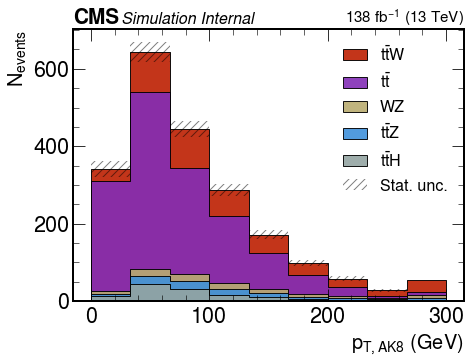

In [3]:
path = 'output/ttW_nottag/'
bins = np.linspace(0, 300, 10)

hist_list, w2_list = get_ttWhists(path, bins, 'lep_pt')

WZ_bins = combine_bins([hist_list[0]])
TTH_bins = combine_bins([hist_list[1]])
TTZ_bins = combine_bins([hist_list[2]])
TT_bins = combine_bins([hist_list[3], hist_list[4]])
TTW_bins = combine_bins([hist_list[5]])

data = [TTH_bins, TTZ_bins, WZ_bins, TT_bins, TTW_bins]
w2s = combine_w2s(w2_list)
labels = ['ttH', 'ttZ', 'WZ', 'tt', 'ttW']
plot(r'p$_{t}$ of leading leptons (ttW 2 lep SS selection with boosted top quarks)', data, w2s, bins, 'AK8pt', labels, 'None')

<AxesSubplot:xlabel='$p_{T, AK8}$ (GeV)', ylabel='N$_{events}$'>

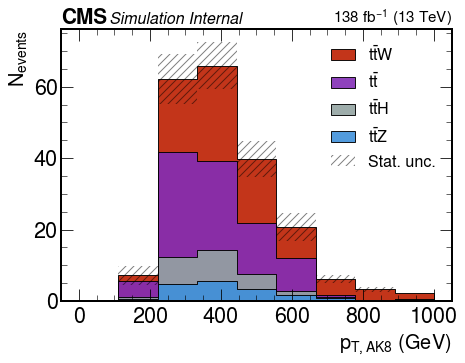

In [4]:
path = 'output/ttW_LWPttag'
var = 'AK8_pt'
bins = np.linspace(0, 1000, 10)

hist_list, w2_list = get_ttWhists(path, bins, var)

WZ_bins = combine_bins([hist_list[0]])
TTH_bins = combine_bins([hist_list[1]])
TT_bins = combine_bins([hist_list[3], hist_list[4]])
TTW_bins = combine_bins([hist_list[5]])
TTZ_bins = combine_bins([hist_list[2]])

WZ_w2s = combine_w2s([hist_list[0]])
TTH_w2s = combine_w2s([hist_list[1]])
TT_w2s = combine_w2s([hist_list[3], hist_list[4]])
TTW_w2s = combine_w2s([hist_list[5]])
TTZ_w2s = combine_w2s([hist_list[2]])

data = [TTZ_bins, TTH_bins, TT_bins, TTW_bins]
w2s = combine_w2s(w2_list)
labels = ['ttZ', 'ttH', 'tt', 'ttW']
plot(r'p$_{T}$ of leading AK8-jet (ttW 2 lep SS selection with boosted top quarks)', data, w2s, bins, 'AK8pt', labels, 'None')

(0.0, 19.60145229945186)

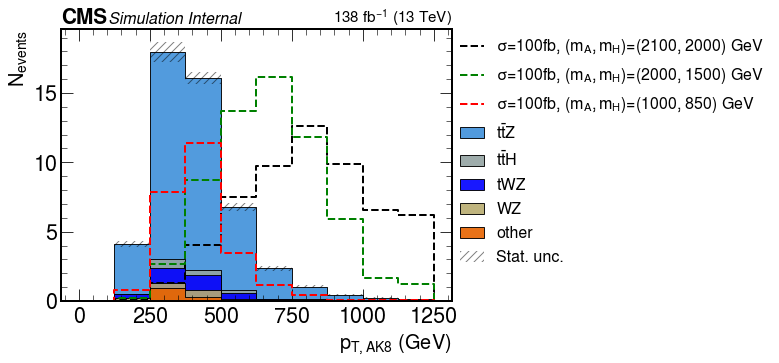

In [8]:
path = 'final_results/ttZ3l_LWPttagm/'
var = 'AK8_pt'
bins = np.linspace(0, 1250, 11)

hist_list, w2_list = get_ttZ3lhists(path, bins, var)

ttZ_bins = combine_bins([hist_list[0]])
other_bins = combine_bins([hist_list[1], hist_list[3],
                          hist_list[7], hist_list[8], hist_list[9], hist_list[10]])
WZ_bins = combine_bins(hist_list[5:7])
TTH_bins = combine_bins([hist_list[2]])
TWZ_bins = combine_bins([hist_list[4]])


ttZ_w2s = combine_w2s([w2_list[0]])
other_w2s = combine_w2s([w2_list[1], w2_list[3], w2_list[5], w2_list[6],
                          w2_list[7], w2_list[8], w2_list[9], w2_list[10]])
TTH_w2s = combine_w2s([w2_list[2]])
TWZ_w2s = combine_w2s([w2_list[4]])

data = [other_bins, WZ_bins, TWZ_bins, TTH_bins, ttZ_bins]
w2s = combine_w2s(w2_list)
labels = ['other', 'WZ', 'tWZ', 'ttH', 'ttZ']

ax = plot(r'p$_{T}$ of leading AK8-jets (ttZ 3 lep OSSF selection with boosted top quarks)', data, w2s, bins, 'AK8pt', labels, 'None')

bins2 = np.linspace(0, 1250, 11)

DF_AH1 = read_file('final_results/ttZ3l_LWPttagm//output_AH/out0.txt')
DF_AH1['SumWeight'] = DF_AH1['sumWeight'][0]
DF_AH2 = read_file('final_results/ttZ3l_LWPttagm//output_AH/out1.txt')
DF_AH2['SumWeight'] = DF_AH2['sumWeight'][0]
DF_AH3 = read_file('final_results/ttZ3l_LWPttagm//output_AH/out2.txt')
DF_AH3['SumWeight'] = DF_AH3['sumWeight'][0]
AH1_bins, w2_AH1 = get_hist(DF_AH1, bins2, var)
AH2_bins, w2_AH2 = get_hist(DF_AH2, bins2, var)
AH3_bins, w2_AH3 = get_hist(DF_AH3, bins, var)


hep.histplot(AH1_bins, bins2,  color='black',  ls='dashed', ax=ax, linewidth=2, label= r'$\sigma$=100fb, $(m_A, m_H)$=(2100, 2000) GeV', binwnorm=None)
hep.histplot(AH2_bins, bins2,  color='g', ls='dashed', ax=ax, linewidth=2,label= r'$\sigma$=100fb, $(m_A, m_H)$=(2000, 1500) GeV', binwnorm=None)
hep.histplot(AH3_bins, bins,  color='r',  ls='dashed',ax=ax, linewidth=2, label= r'$\sigma$=100fb, $(m_A, m_H)$=(1000, 850) GeV', binwnorm=None)
#ax.set_ylim(bottom=0, top=25)
#ax.legend(loc=9, borderaxespad=0., fontsize=12, ncol=3)

ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., fontsize=16)
ax.set_ylim(bottom=0, top=None)


In [6]:
N_AH = {'AH1': 0.266,'AH2': 29, 'AH3': 137.8}

def get_AHhist(DF, nbins, var, mod):
    DF['w'] = DF.genWeights * (N_AH[mod] / DF.SumWeight)
    DF['w2'] = np.square(DF.w)
    if type(nbins)==int:
        clipped = DF[var]
    else:
        clipped = np.clip(DF[var], nbins[0], nbins[-1])
    
    hist, _ = np.histogram(clipped, bins=nbins, weights=DF.w)
    w2, _ = np.histogram(clipped, bins=nbins, weights=DF.w2)
    w = np.sqrt(w2)
    return hist, w

In [9]:
path = 'output/ttZ2l_ttag'
#path = 'ttZ2l/output/'
bins = np.linspace(0, 300, 10)
var= 'Ht'

hist_list, w2_list = get_ttZ2lhists(path, bins, var)

other_bins = combine_bins(hist_list[1:5])
tt_bins = combine_bins([hist_list[9]])
ttZ_bins = combine_bins([hist_list[0]])
WZ_bins = combine_bins(hist_list[5:7])
ZZ_bins = combine_bins(hist_list[7:9])
DYJets_bins = combine_bins(hist_list[10:])

other_w2s = combine_bins(w2_list[1:9])
tt_w2s = combine_bins([w2_list[9]])
ttZ_w2s = combine_bins([w2_list[0]])
DYJets_w2s = combine_bins(w2_list[10:])


data = [other_bins, WZ_bins, ZZ_bins, tt_bins, DYJets_bins, ttZ_bins]
w2s = combine_w2s(w2_list)

labels = ['other', 'WZ', 'ZZ', 'tt', 'DYJets', 'ttZ']
ax = plot(r'p$_{T}$ of leading AK4-jets (ttZ 2 lep)', data, w2s, bins, 'AK8pt', labels, 'SBG')


# bins2 = np.linspace(0, 250, 10)
# DF_AH1 = read_file('output/ttZ2l_MWPttag/output_AH/out0.txt')
# DF_AH1['SumWeight'] = DF_AH1['sumWeight'][0]
# DF_AH2 = read_file('output/ttZ2l_MWPttag/output_AH/out1.txt')
# DF_AH2['SumWeight'] = DF_AH2['sumWeight'][0]
# DF_AH3 = read_file('output/ttZ2l_MWPttag/output_AH/out2.txt')
# DF_AH3['SumWeight'] = DF_AH3['sumWeight'][0]
# AH1_bins, w2_AH1 = get_hist(DF_AH1, bins2, var)
# AH2_bins, w2_AH2 = get_hist(DF_AH2, bins2, var)
# AH3_bins, w2_AH3 = get_hist(DF_AH3, bins, var)

# hep.histplot(AH1_bins, bins2,  color='black', ls='dashed', ax=ax, linewidth=2,label= r'$(m_A, m_H)$=(2100, 2000) GeV', binwnorm=None)
# hep.histplot(AH2_bins, bins2,  color='g', ls='dashed', ax=ax, linewidth=2,label= r'$(m_A, m_H)$=(2000, 1500) GeV', binwnorm=None)
# hep.histplot(AH3_bins, bins,  color='r', ls='dashed', ax=ax, linewidth=2, label= r'$(m_A, m_H)$=(1000, 850) GeV', binwnorm=None)
# #ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., fontsize=16)
# #ax.set_ylim(bottom=0, top=None)

# ax.set_ylim(bottom=0, top=110)
# ax.legend(loc=9, borderaxespad=0., fontsize=11, ncol=4)


KeyError: 'Ht'

<AxesSubplot:xlabel='$p_{T, lep}$ (GeV)', ylabel='N$_{events}$'>

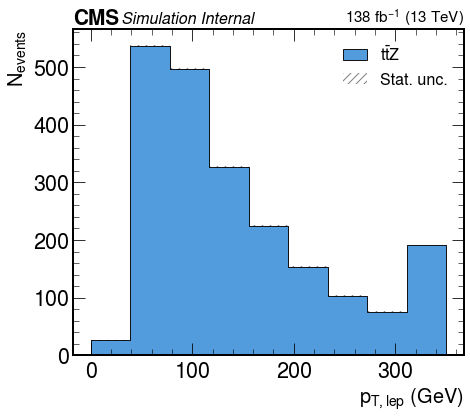

In [ ]:
path = 'output/ttZ2l_nottag'
#path = 'ttZ2l/output/'
bins = np.linspace(0, 350, 10)
var= 'lep_pt'

hist_list, w2_list = get_ttZ2lhists(path, bins, var)

data = hist_list[0]
w2s = combine_w2s([w2_list[0]])
labels = ['ttZ']

plot(r'p$_{T}$ of leading AK8-jets (ttZ 3 lep OSSF selection with boosted top quarks)', data, w2s, bins, 'AK8pt', labels, 'None')

<AxesSubplot:xlabel='$p_{T, AK8}$ (GeV)', ylabel='N$_{events}$'>

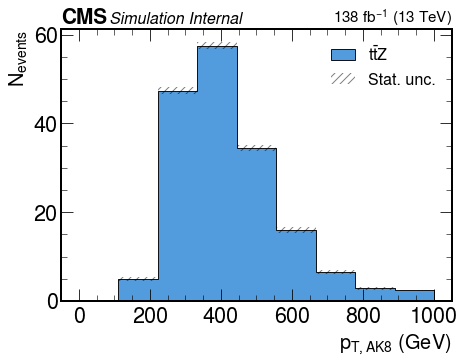

In [ ]:
path = 'output/ttZ2l_Lttag'
#path = 'ttZ2l/output/'
bins = np.linspace(0, 1000, 10)
var= 'AK8_pt'

hist_list, w2_list = get_ttZ2lhists(path, bins, var)

data = hist_list[0]
w2s = combine_w2s([w2_list[0]])
labels = ['ttZ']

plot(r'p$_{T}$ of leading AK8-jets (ttZ 3 lep OSSF selection with boosted top quarks)', data, w2s, bins, 'AK8pt', labels, 'None')

<AxesSubplot:xlabel='$p_{T, AK8}$ (GeV)', ylabel='N$_{events}$'>

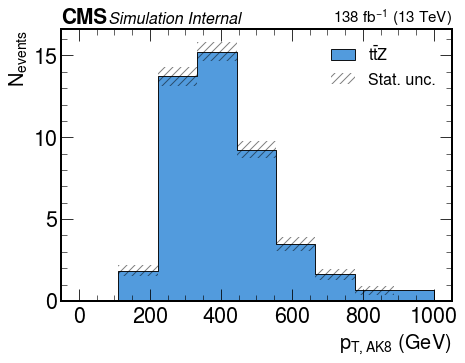

In [ ]:
path = 'output/ttZ3l_ttag'
#path = 'ttZ2l/output/'
bins = np.linspace(0, 1000, 10)
var= 'AK8_pt'

hist_list, w2_list = get_ttZ3lhists(path, bins, var)

data = hist_list[0]
w2s = combine_w2s([w2_list[0]])
labels = ['ttZ']

plot(r'p$_{T}$ of leading AK8-jets (ttZ 3 lep OSSF selection with boosted top quarks)', data, w2s, bins, 'AK8pt', labels, 'None')

<AxesSubplot:xlabel='$p_{T, AK8}$ (GeV)', ylabel='N$_{events}$'>

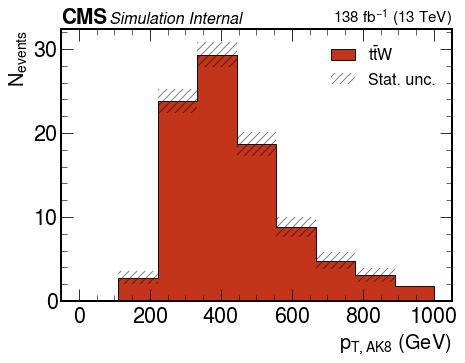

In [ ]:
path = 'output/ttW_ttag'
#path = 'ttZ2l/output/'
bins = np.linspace(0, 1000, 10)
var= 'AK8_pt'

hist_list, w2_list = get_ttWhists(path, bins, var)

data = hist_list[5]
w2s = combine_w2s([w2_list[5]])
labels = ['ttW']

plot(r'p$_{T}$ of leading AK8-jets (ttZ 3 lep OSSF selection with boosted top quarks)', data, w2s, bins, 'AK8pt', labels, 'None')

(0.0, 10479.16746296005)

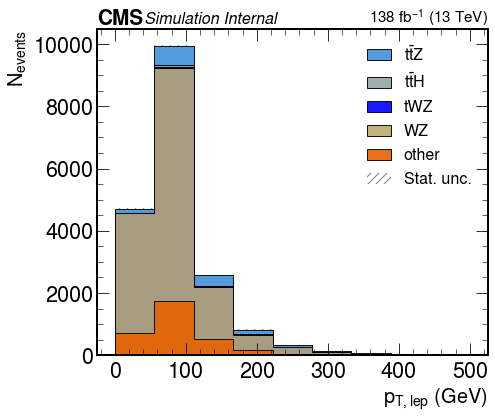

In [ ]:
path = 'ttZ3l/output/'
#path = 'ttZ2l/output/'
bins = np.linspace(0, 500, 10)
var= 'lep_pt'

hist_list, w2_list = get_ttZ3lhists(path, bins, var)

ttZ_bins = combine_bins([hist_list[0]])
other_bins = combine_bins([hist_list[1], hist_list[3],
                          hist_list[7], hist_list[8], hist_list[9], hist_list[10]])
WZ_bins = combine_bins(hist_list[5:7])
TTH_bins = combine_bins([hist_list[2]])
TWZ_bins = combine_bins([hist_list[4]])


ttZ_w2s = combine_w2s([w2_list[0]])
other_w2s = combine_w2s([w2_list[1], w2_list[3], w2_list[5], w2_list[6],
                          w2_list[7], w2_list[8], w2_list[9], w2_list[10]])
TTH_w2s = combine_w2s([w2_list[2]])
TWZ_w2s = combine_w2s([w2_list[4]])

data = [other_bins, WZ_bins, TWZ_bins, TTH_bins, ttZ_bins]
w2s = combine_w2s(w2_list)
labels = ['other', 'WZ', 'tWZ', 'ttH', 'ttZ']

ax = plot(r'', data, w2s, bins, 'leppt', labels, 'None')

ax.set_ylim(bottom=0)

(0.0, 346.9881822977129)

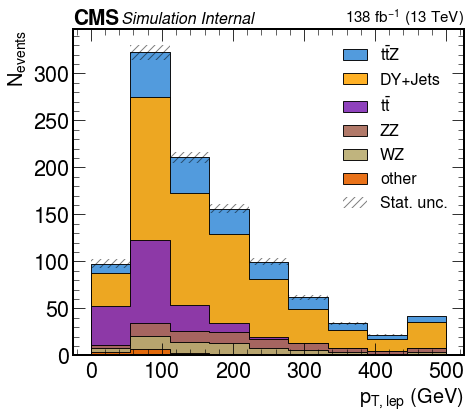

In [ ]:
path = 'ttZ2l/output/'
#path = 'ttZ2l/output/'
bins = np.linspace(0, 500, 10)
var= 'lep_pt'

hist_list, w2_list = get_ttZ2lhists(path, bins, var)

other_bins = combine_bins(hist_list[1:5])
tt_bins = combine_bins([hist_list[9]])
ttZ_bins = combine_bins([hist_list[0]])
WZ_bins = combine_bins(hist_list[5:7])
ZZ_bins = combine_bins(hist_list[7:9])
DYJets_bins = combine_bins(hist_list[10:])

other_w2s = combine_bins(w2_list[1:9])
tt_w2s = combine_bins([w2_list[9]])
ttZ_w2s = combine_bins([w2_list[0]])
DYJets_w2s = combine_bins(w2_list[10:])


data = [other_bins, WZ_bins, ZZ_bins, tt_bins, DYJets_bins, ttZ_bins]
w2s = combine_w2s(w2_list)

labels = ['other', 'WZ', 'ZZ', 'tt', 'DYJets', 'ttZ']
ax = plot(r'', data, w2s, bins, 'leppt', labels, 'None')

ax.set_ylim(bottom=0)

(0.0, 14226.805273360125)

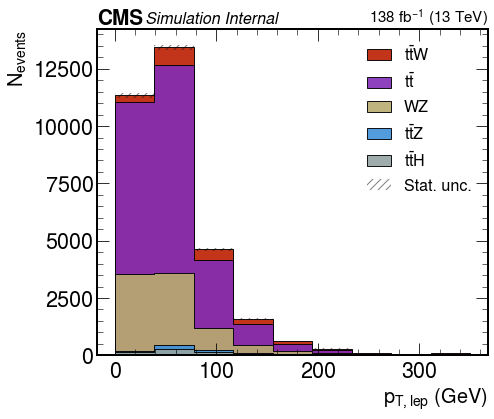

In [ ]:
path = 'ttW/output/'
#path = 'ttZ2l/output/'
bins = np.linspace(0, 350, 10)
var= 'lep_pt'

hist_list, w2_list = get_ttWhists(path, bins, var)

WZ_bins = combine_bins([hist_list[0]])
TTH_bins = combine_bins([hist_list[1]])
TTZ_bins = combine_bins([hist_list[2]])
TT_bins = combine_bins([hist_list[3], hist_list[4]])
TTW_bins = combine_bins([hist_list[5]])

data = [TTH_bins, TTZ_bins, WZ_bins, TT_bins, TTW_bins]
w2s = combine_w2s(w2_list)
labels = ['ttH', 'ttZ', 'WZ', 'tt', 'ttW']
ax = plot(r'', data, w2s, bins, 'leppt', labels, 'None')

ax.set_ylim(bottom=0)